In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tkinter as tk
from PIL import Image, ImageDraw

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from scipy.ndimage import rotate, shift, zoom

In [25]:
from model.neural_network import NeuralNetwork
from model.layers.dense import DenseLayer
from model.layers.dropout import DropoutLayer
from model.optimizers.adam import Adam

In [26]:
sns.set_style('darkgrid')

# MNIST Dataset

In [27]:
mnist = fetch_openml('mnist_784')
X = mnist['data'].to_numpy() / 255.0
y = mnist['target'].astype(int).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=10000,
    random_state=42,
    stratify=y
)

In [28]:
def noisy_image(image, img_size=28):
    if len(image.shape) == 1:
        img = image.reshape(img_size, img_size)
    else:
        img = image.copy()

    # Random rotation (-20 to +20 degrees)
    angle = np.random.uniform(-20, 20)
    img = rotate(img, angle, reshape=False, mode='constant', cval=0)

    # Random scaling (0.8 to 1.2)
    scale = np.random.uniform(0.8, 1.2)
    if scale != 1.0:
        zoomed = zoom(img, scale, order=1, mode='constant', cval=0)

        if scale > 1.0:
            start = (zoomed.shape[0] - img_size) // 2
            img = zoomed[start:start+img_size, start:start+img_size]
        else:
            pad_total = img_size - zoomed.shape[0]
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            img = np.pad(zoomed, ((pad_before, pad_after), (pad_before, pad_after)), mode='constant', constant_values=0)

    # Random offset (-4 to +4 pixels)
    shift_x = np.random.uniform(-4, 4)
    shift_y = np.random.uniform(-4, 4)
    img = shift(img, [shift_y, shift_x], mode='constant', cval=0)

    # Add random noise (gaussian noise with small std)
    std = np.random.uniform(0, 0.1)
    noise = np.random.normal(0, std, img.shape)
    img = img + noise

    # Clip values to [0, 1] range
    img = np.clip(img, 0, 1)

    return img.flatten()


x_train = np.array([noisy_image(img) for img in x_train])

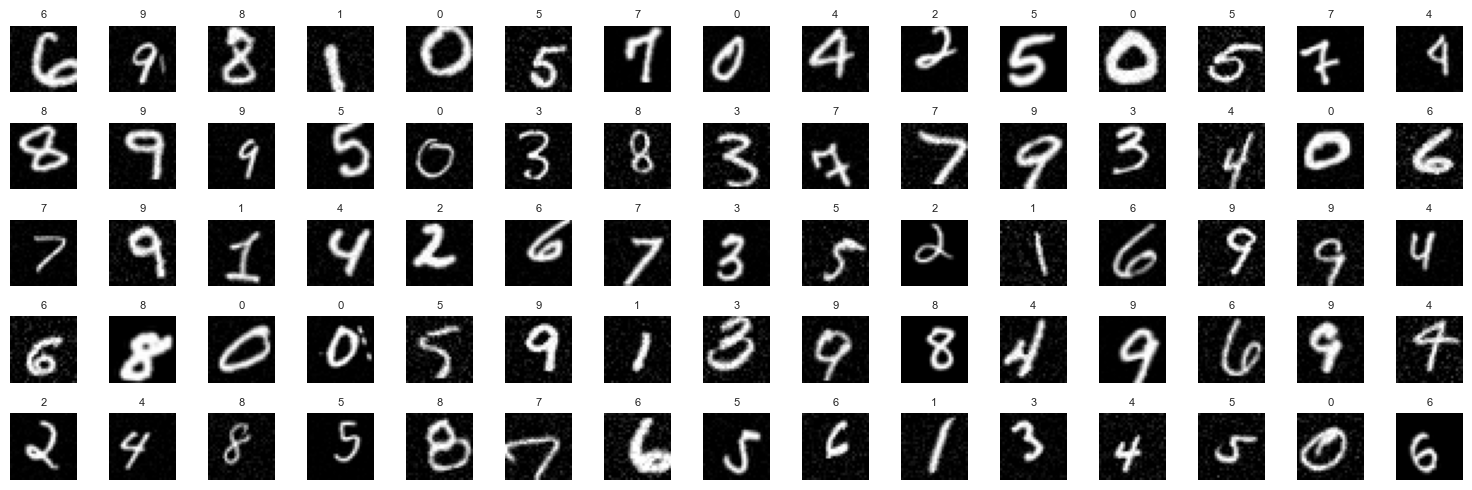

In [29]:
num_images = 75
num_cols = 15
num_rows = num_images // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(str(y_train[i]), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
x_train

array([[0.00088983, 0.00080833, 0.01818391, ..., 0.01187852, 0.        ,
        0.        ],
       [0.01268867, 0.00502941, 0.07087557, ..., 0.03388203, 0.        ,
        0.03453686],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02618834],
       ...,
       [0.        , 0.        , 0.00821144, ..., 0.        , 0.03433772,
        0.01013682],
       [0.031846  , 0.        , 0.00095915, ..., 0.01662752, 0.        ,
        0.        ],
       [0.        , 0.00400275, 0.0036631 , ..., 0.        , 0.        ,
        0.00509765]], shape=(60000, 784))

# Training

In [31]:
def to_categorical(y, num_classes):
    y = np.asarray(y, dtype=int)
    return np.eye(num_classes)[y]

In [32]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = NeuralNetwork([
    DenseLayer(784, 128, activation='Relu', weight_regularizer_l2=1e-4),
    DropoutLayer(rate=0.05),
    DenseLayer(128, 64, activation='Relu', weight_regularizer_l2=1e-4),
    DropoutLayer(rate=0.05),
    DenseLayer(64, 10, activation='Softmax')
])

model.set(
    loss='CategoricalCrossentropy',
    optimizer=Adam(learning_rate=0.001, decay=5e-4)
)

model.train(x_train, y_train, epochs=1000, print_every=5, validation_data=(x_test, y_test), patience=10, min_delta=0.005)

accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}%')

epoch: 0, loss: 2.34379, acc: 8.20%, lr: 0.0010000000
epoch: 5, loss: 2.28893, acc: 20.26%, lr: 0.0009980040
epoch: 10, loss: 2.18881, acc: 26.81%, lr: 0.0009955202
epoch: 15, loss: 2.03246, acc: 54.08%, lr: 0.0009930487
epoch: 20, loss: 1.81160, acc: 64.26%, lr: 0.0009905894
epoch: 25, loss: 1.56619, acc: 65.15%, lr: 0.0009881423
epoch: 30, loss: 1.36341, acc: 65.13%, lr: 0.0009857072
epoch: 35, loss: 1.24105, acc: 65.45%, lr: 0.0009832842
epoch: 40, loss: 1.18550, acc: 66.49%, lr: 0.0009808730
epoch: 45, loss: 1.14172, acc: 67.68%, lr: 0.0009784736
epoch: 50, loss: 1.08865, acc: 71.11%, lr: 0.0009760859
epoch: 55, loss: 1.01973, acc: 73.78%, lr: 0.0009737098
epoch: 60, loss: 0.94010, acc: 76.52%, lr: 0.0009713453
epoch: 65, loss: 0.87145, acc: 78.51%, lr: 0.0009689922
epoch: 70, loss: 0.80933, acc: 80.34%, lr: 0.0009666506
epoch: 75, loss: 0.74703, acc: 81.77%, lr: 0.0009643202
epoch: 80, loss: 0.69846, acc: 82.77%, lr: 0.0009620010
epoch: 85, loss: 0.65873, acc: 83.03%, lr: 0.000959

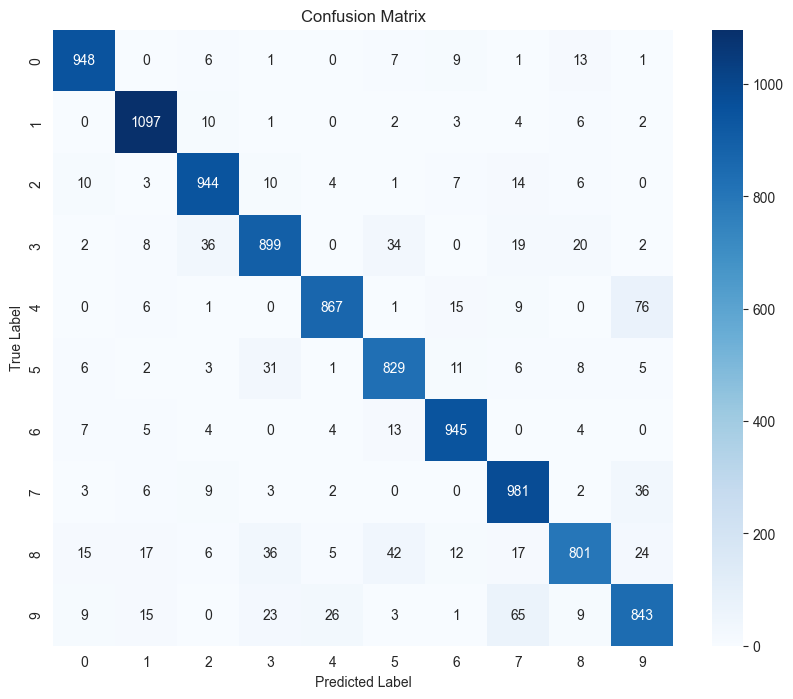

In [33]:
y_pred_probs = model.forward(x_test)

y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Testing

In [34]:
class DigitRecognizer:
    def __init__(self, model):
        self.model = model
        self.window = tk.Tk()
        self.window.title('Draw a Digit')

        self.canvas = tk.Canvas(self.window, width=280, height=280, bg='black')
        self.canvas.pack()

        self.button_frame = tk.Frame(self.window)
        self.button_frame.pack()

        self.predict_button = tk.Button(self.button_frame, text='Predict', command=self.predict_digit)
        self.predict_button.pack(side='left')

        self.clear_button = tk.Button(self.button_frame, text='Clear', command=self.clear_canvas)
        self.clear_button.pack(side='right')

        self.canvas.bind('<B1-Motion>', self.draw)

        self.image = Image.new('L', (280, 280), color=0)
        self.draw_image = ImageDraw.Draw(self.image)

        self.pixel_size = 10

        self.window.mainloop()

    def draw(self, event):
        x, y = event.x, event.y

        self.canvas.create_rectangle(
            x, y,
            x + self.pixel_size, y + self.pixel_size,
            fill='white', outline='white'
        )

        self.draw_image.rectangle(
            [x, y, x + self.pixel_size, y + self.pixel_size],
            fill=255
        )

    def clear_canvas(self):
        self.canvas.delete('all')
        self.draw_image.rectangle([0, 0, 280, 280], fill=0)

    def predict_digit(self):
        resized = self.image.resize((28, 28))
        data = np.asarray(resized).astype(np.float32) / 255.0
        data = data.reshape(1, -1)

        prediction = self.model.forward(data)
        predicted_class = np.argmax(prediction)
        print(f'Predicted digit: {predicted_class}')

        self.window.title(f'Predicted digit: {predicted_class}')

In [35]:
DigitRecognizer(model)